In [1]:
import numpy as np
from scipy.io import loadmat
import scipy.optimize as opt
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# 读入数据
def loadData(path):
    data = loadmat(path)
    X, y, Xval, yval, Xtest, ytest = data['X'], data['y'], data['Xval'], data['yval'], data['Xtest'], data['ytest']
    return X, y, Xval, yval, Xtest, ytest


In [3]:
path = r'ex8data1.mat'
X, y, Xval, yval, Xtest, ytest = loadData(path)
print(X.shape, y.shape, Xval.shape, yval.shape, Xtest.shape, ytest.shape)

(12, 1) (12, 1) (21, 1) (21, 1) (21, 1) (21, 1)


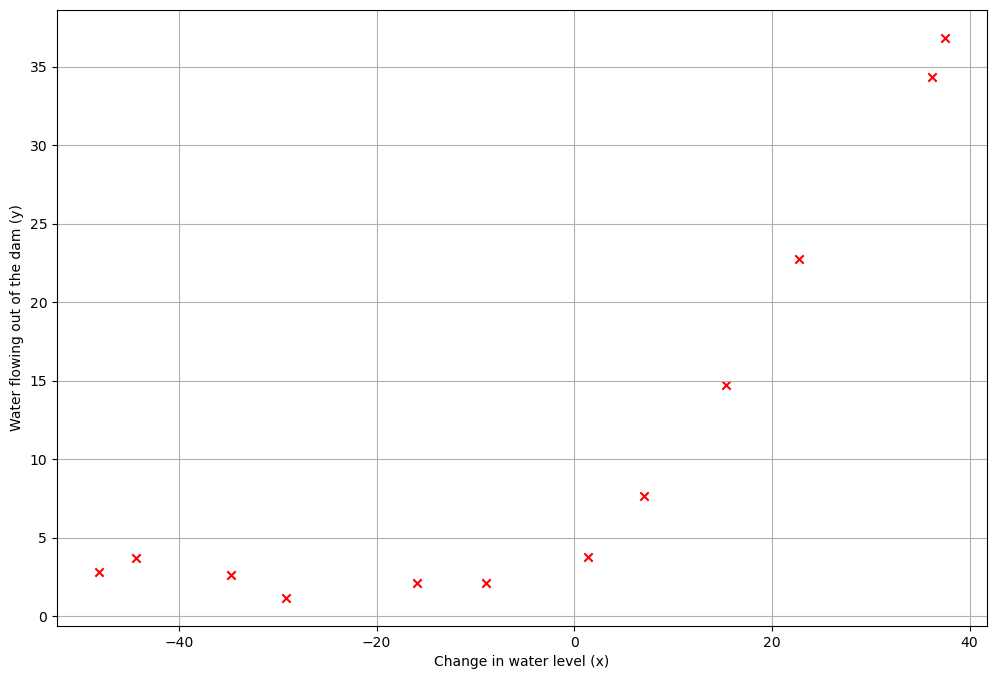

In [4]:
# 可视化
def plotData(X,y):
    plt.figure(figsize=(12,8))
    plt.scatter(X, y,c='r', marker='x')
    plt.xlabel('Change in water level (x)')
    plt.ylabel('Water flowing out of the dam (y)')
    plt.grid(True)
plotData(X,y)

In [5]:
# 插入x0 = 1
X, Xval, Xtest = [np.insert(x, 0, np.ones(x.shape[0]), axis=1) for x in (X, Xval, Xtest)]
print(X.shape, Xval.shape, Xtest.shape)
# ((12, 2), (21, 2), (21, 2))

(12, 2) (21, 2) (21, 2)


In [6]:

 
# 代价函数
def linearRegCostFunc(theta, X, y, l=1):
    m = X.shape[0] # 12

    
    # 计算误差的平方
    error = np.dot(X, theta) - y.flatten()
    
    # 计算正则化项
    regularization = (l / (2 * m)) * np.sum(theta[1:] ** 2)
    
    # 计算代价函数
    cost = (1 / (2 * m)) * np.sum(np.square(error)) + regularization
    
    return cost

theta=np.ones(X.shape[1])
linearRegCostFunc(theta, X, y)

303.9931922202643

In [7]:
# 正则化梯度下降
def linearRegCostFuncGradient(theta, X,y, l=1):
    m = X.shape[0] # 12
    theta_grad = np.zeros(theta.shape)

    h_theta = np.dot(X, theta)
    error = h_theta - y.flatten()

    for j in range(len(theta)):
        if j == 0:
            theta_grad[j] = np.sum(error * X[:, j]) / m
        else:
            theta_grad[j] = np.sum(error * X[:, j]) / m + l / m * theta[j]

    return theta_grad
    return grad # (2,1)

linearRegCostFuncGradient(theta,X,y)

array([-15.30301567, 598.25074417])

In [8]:
def trainLinearRegression(X,y,lmd):
    theta=np.zeros(X.shape[1])
    rslt = opt.minimize(fun=linearRegCostFunc,x0=theta,args=(X,y,lmd),
                     method='TNC',jac=linearRegCostFuncGradient)
    return rslt.x

fit_theta=trainLinearRegression(X,y,0)
fit_theta


array([13.08790351,  0.36777923])

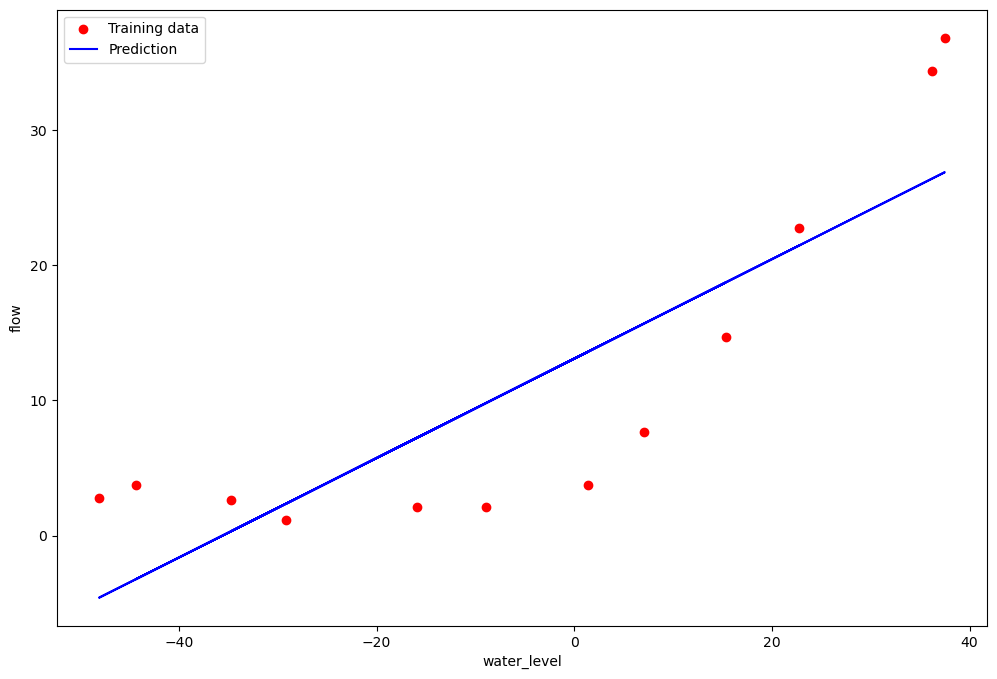

In [9]:
def plotData1(theta, X, y):
    fig,ax = plt.subplots(figsize=(12,8))
    plt.scatter(X[:,1], y, c='r', label="Training data")
    plt.plot(X[:,1], X @ theta, c = 'b', label="Prediction")
    ax.set_xlabel("water_level")
    ax.set_ylabel("flow")
    ax.legend()
    plt.show()

plotData1(fit_theta, X, y)

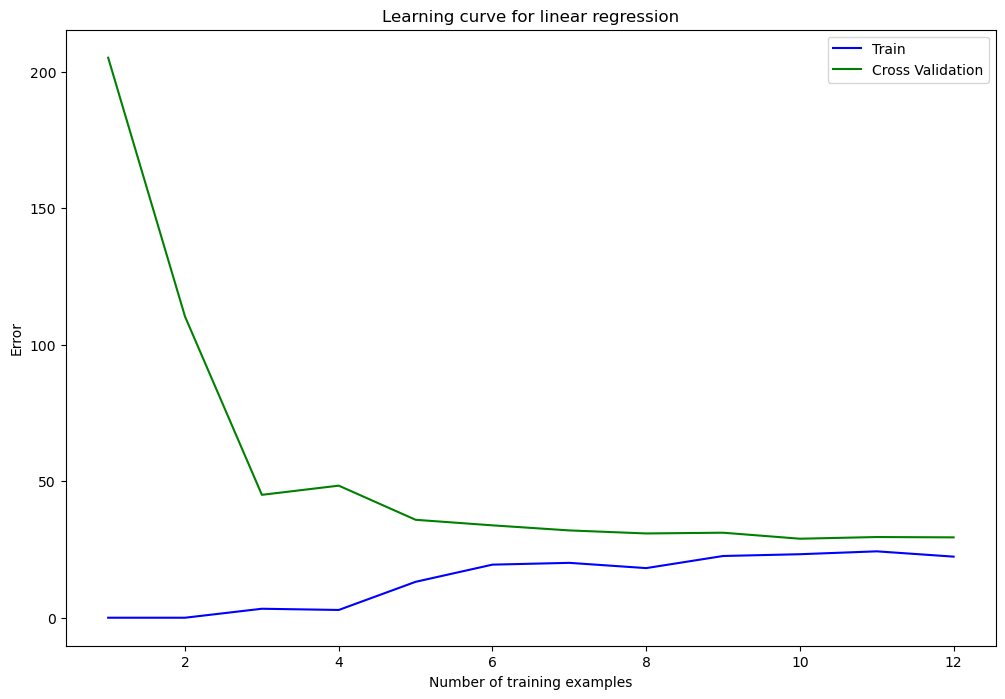

In [10]:

def plotLearningCurve(X, y, Xval, yval, l):
    """画出学习曲线"""
    size = range(1, len(X)+1)
    error_train, error_val = [], []
    for i in size:
        i_theta = trainLinearRegression(X[:i, :], y[:i], l)
        i_train_cost = linearRegCostFunc(i_theta, X[:i, :], y[:i], 0)
        i_val_cost = linearRegCostFunc(i_theta, Xval, yval)
        error_train.append(i_train_cost)
        error_val.append(i_val_cost)

    
    fix, ax = plt.subplots(figsize=(12, 8))
    ax.plot(size,error_train,label="Train",color="blue")
    ax.plot(size,error_val,label="Cross Validation",color="green")
    ax.legend()
    ax.set_xlabel("Number of training examples")
    ax.set_ylabel("Error")
    ax.set_title("Learning curve for linear regression")
    ax.grid(False)
    plt.show()

plotLearningCurve(X, y, Xval, yval, 0)

In [11]:
def polyFeatures(X, power):
    """
    多项式特征
    每次在X最后一列添加次方项
    从第三列开始插入，因为X本身含有一列x0 = 1（这里假设X的第一列是x0=1，根据描述，实际上应该是从第二列开始变换）
    """
    Xpoly = X.copy()
    for i in range(1, power):  
        if i == 0 or i == 1:  
            continue
        tmp = Xpoly[:, 1:] ** i  
        if i == 2:  # 第一次循环时直接赋值，后续循环使用hstack
            Xpoly = np.hstack((Xpoly[:, :1], tmp))  # 保留x0=1的列，然后添加变换后的列
        else:
            Xpoly = np.hstack((Xpoly, tmp))
    
    return Xpoly

In [12]:
def get_means_std(X):
    """获得训练集的均值和误差"""
    means = np.mean(X,axis = 0) # 按列
    stds = np.std(X, axis=0, ddof=1)
    print(means.shape,stds.shape)
    return means, stds
 

def featureNormalize(X, means, stds):
    """标准化"""

    X_norm = np.hstack((np.ones((X.shape[0], 1)), ((X[:, 1:] - means[1:]) / stds[1:]).reshape(-1, len(stds)-1)))
    
    return X_norm

In [13]:
# 数据处理
power = 8
train_means, train_stds = get_means_std(polyFeatures(X, power))
X_norm = featureNormalize(polyFeatures(X, power), train_means, train_stds)
Xval_norm = featureNormalize(polyFeatures(Xval, power), train_means, train_stds)
Xtest_norm = featureNormalize(polyFeatures(Xtest, power), train_means, train_stds)

(33,) (33,)


C:\Users\Extinct\AppData\Local\Temp\ipykernel_18152\1086437589.py:11: RuntimeWarning: overflow encountered in power
  tmp = Xpoly[:, 1:] ** i
D:\software\anaconda3\lib\site-packages\numpy\core\_methods.py:230: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
D:\software\anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\Extinct\AppData\Local\Temp\ipykernel_18152\2964578786.py:12: RuntimeWarning: invalid value encountered in subtract
  X_norm = np.hstack((np.ones((X.shape[0], 1)), ((X[:, 1:] - means[1:]) / stds[1:]).reshape(-1, len(stds)-1)))
C:\Users\Extinct\AppData\Local\Temp\ipykernel_18152\2964578786.py:12: RuntimeWarning: invalid value encountered in true_divide
  X_norm = np.hstack((np.ones((X.shape[0], 1)), ((X[:, 1:] - means[1:]) / stds[1:]).reshape(-1, len(stds)-1)))


C:\Users\Extinct\AppData\Local\Temp\ipykernel_18152\1086437589.py:11: RuntimeWarning: overflow encountered in power
  tmp = Xpoly[:, 1:] ** i
C:\Users\Extinct\AppData\Local\Temp\ipykernel_18152\2964578786.py:12: RuntimeWarning: invalid value encountered in subtract
  X_norm = np.hstack((np.ones((X.shape[0], 1)), ((X[:, 1:] - means[1:]) / stds[1:]).reshape(-1, len(stds)-1)))
C:\Users\Extinct\AppData\Local\Temp\ipykernel_18152\2964578786.py:12: RuntimeWarning: invalid value encountered in true_divide
  X_norm = np.hstack((np.ones((X.shape[0], 1)), ((X[:, 1:] - means[1:]) / stds[1:]).reshape(-1, len(stds)-1)))


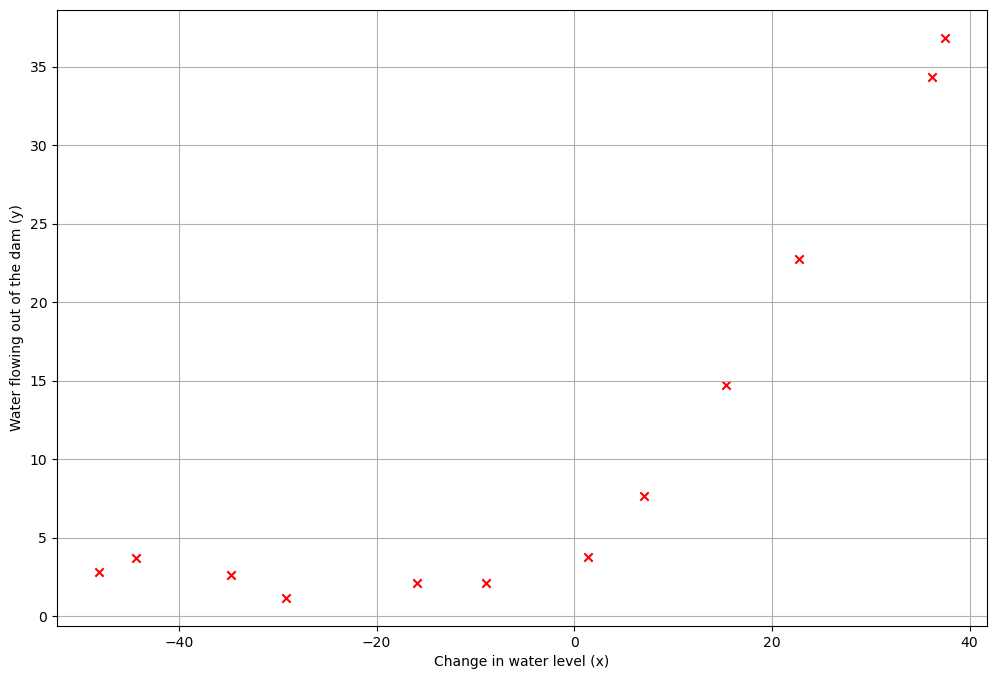

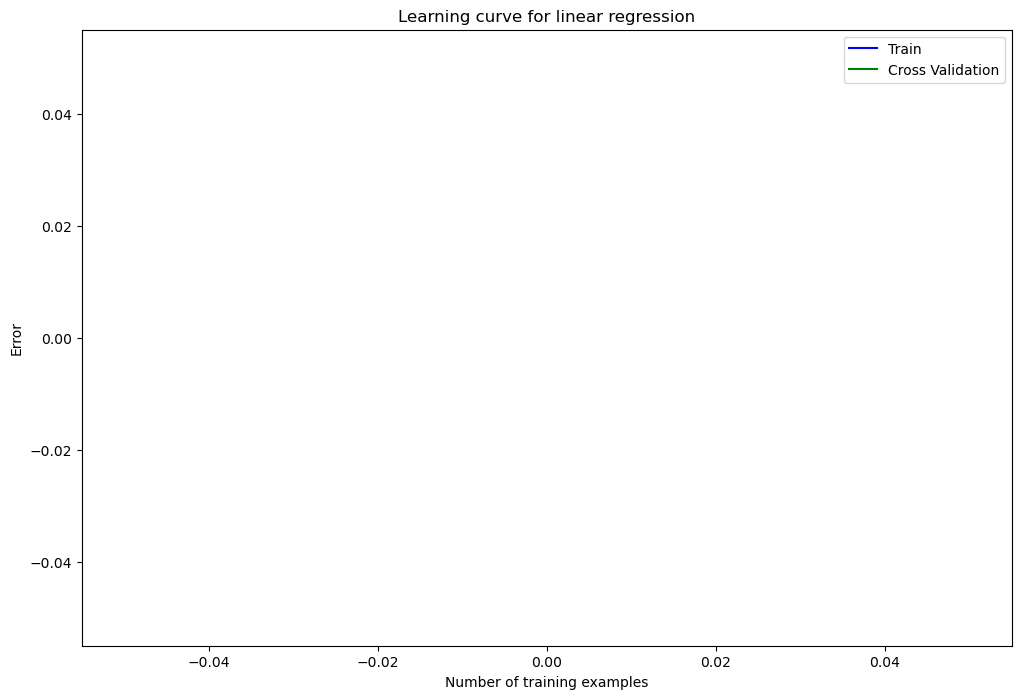

In [14]:
def plot_fit(means, stds, l):
    """画出拟合曲线"""
    theta = trainLinearRegression(X_norm,y, l)
    x = np.linspace(-75,55,50)
    xmat = x.reshape(-1, 1) # (50,)->(50,1)
    xmat = np.insert(xmat,0,1,axis=1) # 添加x0 = 1 
    Xmat = polyFeatures(xmat, power) # 增加特征
    Xmat_norm = featureNormalize(Xmat, means, stds) # 特征规范化
    plotData(X[:,1], y) # 画出原始数据
    plt.plot(x, Xmat_norm @ theta, 'b--')# 画出拟合曲线
    
plot_fit(train_means, train_stds, 0)
plotLearningCurve(X_norm, y, Xval_norm, yval, 0) # 画出学习曲线

C:\Users\Extinct\AppData\Local\Temp\ipykernel_12744\1086437589.py:11: RuntimeWarning: overflow encountered in power
  tmp = Xpoly[:, 1:] ** i
C:\Users\Extinct\AppData\Local\Temp\ipykernel_12744\189397017.py:19: RuntimeWarning: invalid value encountered in subtract
  X_normalized = np.hstack((np.ones((X.shape[0], 1)), ((X[:, 1:] - means[1:]) / stds[1:]).reshape(-1, len(stds)-1)))
C:\Users\Extinct\AppData\Local\Temp\ipykernel_12744\189397017.py:19: RuntimeWarning: invalid value encountered in true_divide
  X_normalized = np.hstack((np.ones((X.shape[0], 1)), ((X[:, 1:] - means[1:]) / stds[1:]).reshape(-1, len(stds)-1)))


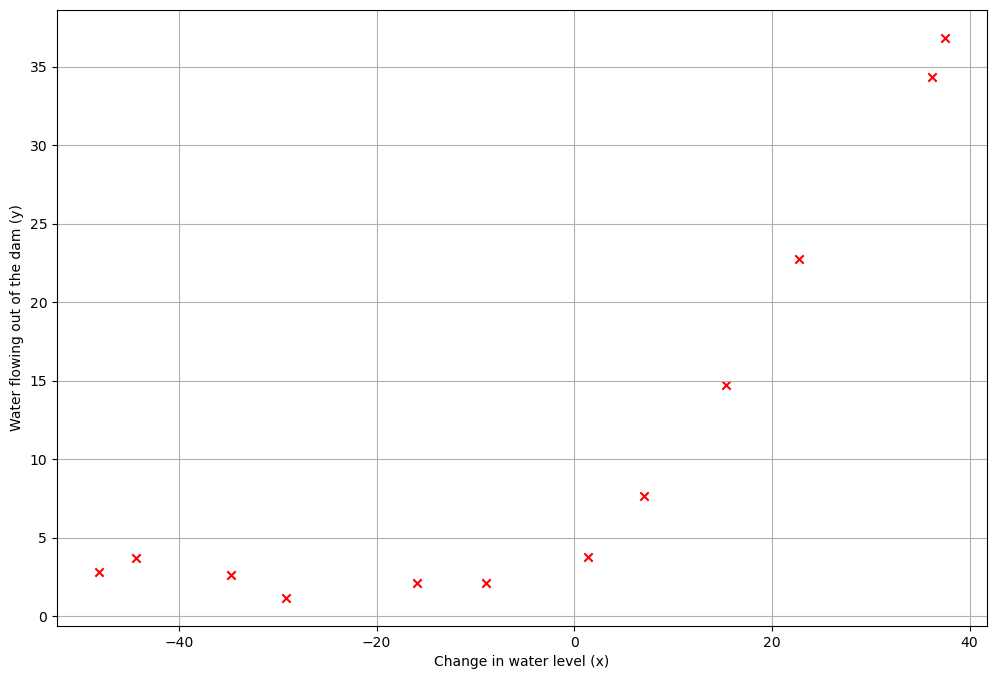

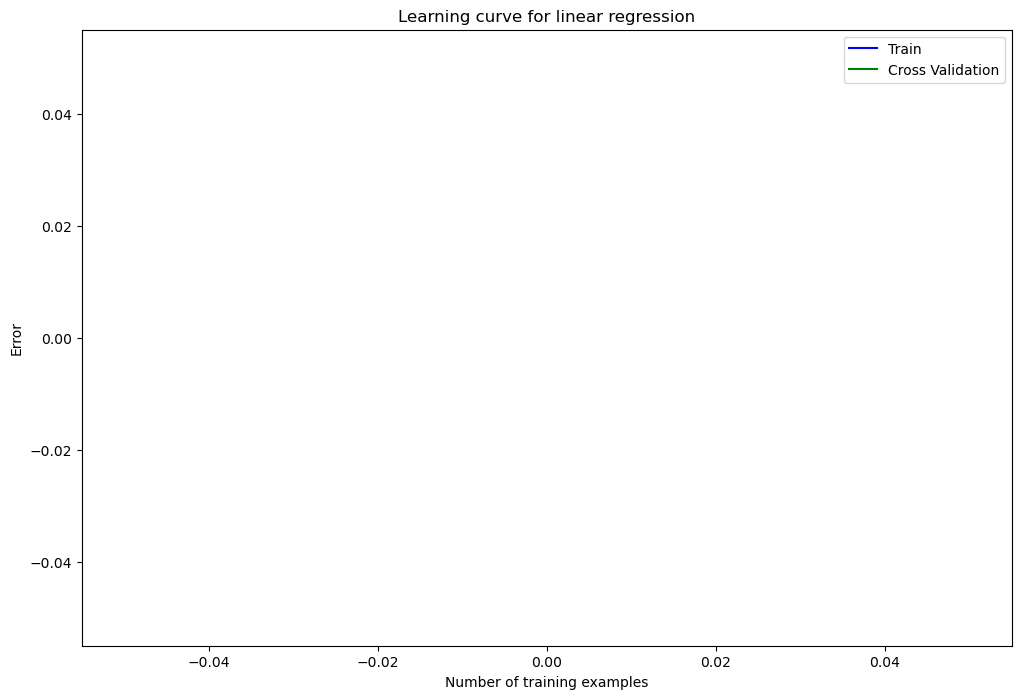

In [56]:
plot_fit(train_means, train_stds, 1)
plotLearningCurve(X_norm, y, Xval_norm, yval, 1) 

C:\Users\Extinct\AppData\Local\Temp\ipykernel_12744\1086437589.py:11: RuntimeWarning: overflow encountered in power
  tmp = Xpoly[:, 1:] ** i
C:\Users\Extinct\AppData\Local\Temp\ipykernel_12744\189397017.py:19: RuntimeWarning: invalid value encountered in subtract
  X_normalized = np.hstack((np.ones((X.shape[0], 1)), ((X[:, 1:] - means[1:]) / stds[1:]).reshape(-1, len(stds)-1)))
C:\Users\Extinct\AppData\Local\Temp\ipykernel_12744\189397017.py:19: RuntimeWarning: invalid value encountered in true_divide
  X_normalized = np.hstack((np.ones((X.shape[0], 1)), ((X[:, 1:] - means[1:]) / stds[1:]).reshape(-1, len(stds)-1)))


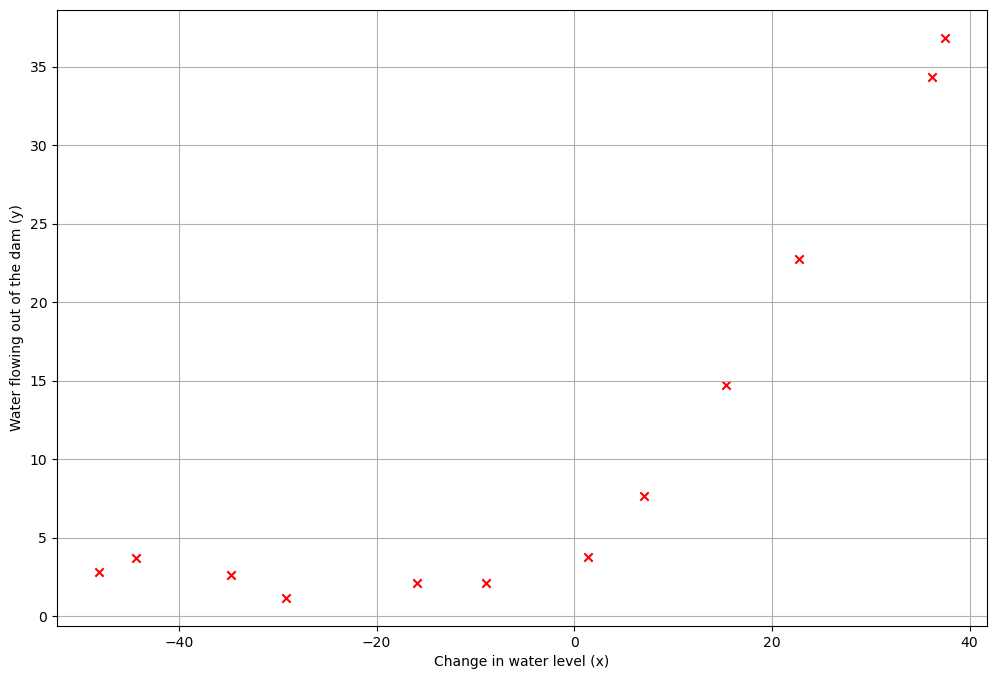

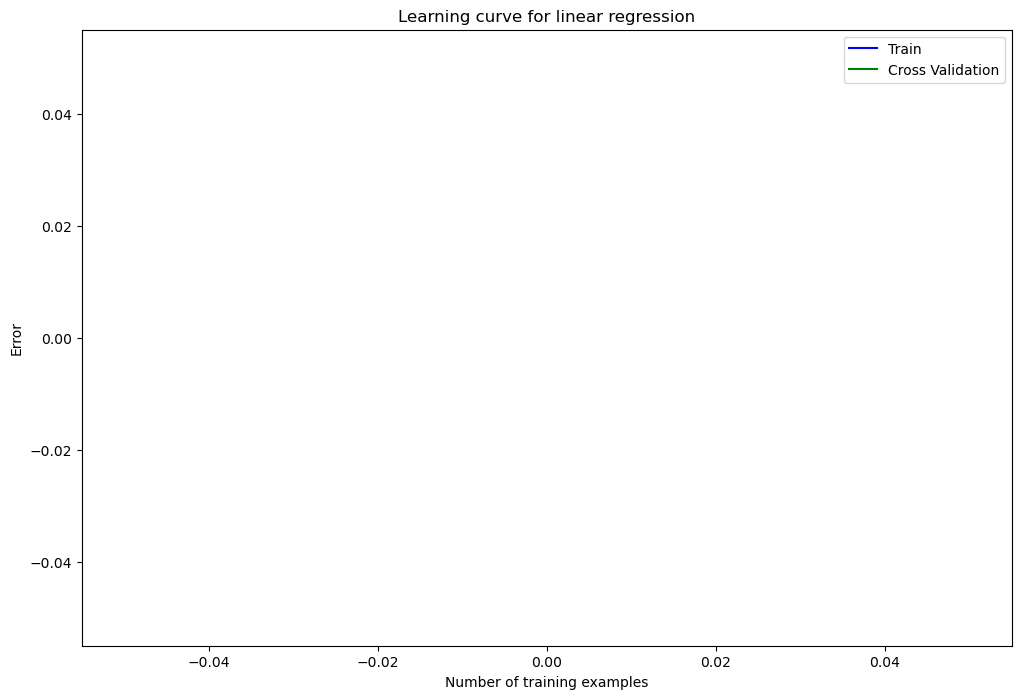

In [57]:
plot_fit(train_means, train_stds, 100)
plotLearningCurve(X_norm, y, Xval_norm, yval, 100) 

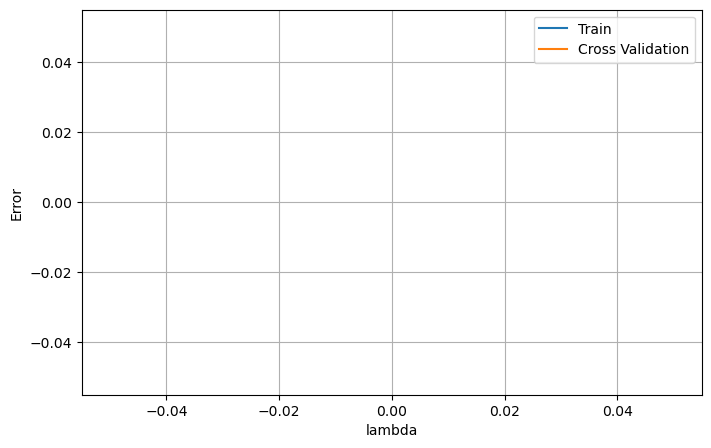

In [58]:
lambdas = [0., 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1., 3., 10.]
errors_train, errors_val = [], []
for l in lambdas:
    theta = trainLinearRegression(X_norm, y, l)
    errors_train.append(linearRegCostFunc(theta,X_norm,y,0))  # 记得把lambda = 0
    errors_val.append(linearRegCostFunc(theta,Xval_norm,yval,0))
    
plt.figure(figsize=(8,5))
plt.plot(lambdas,errors_train,label='Train')
plt.plot(lambdas,errors_val,label='Cross Validation')
plt.legend()
plt.xlabel('lambda')
plt.ylabel('Error')
plt.grid(True)

In [59]:
theta = trainLinearRegression(X_norm, y, 3)
print('test cost(l={}) = {}'.format(3, linearRegCostFunc(theta, Xtest_norm, ytest, 0)))

test cost(l=3) = nan
